In [1]:
import matplotlib
%matplotlib notebook
from matplotlib import pyplot as plt
plt.style.use("fivethirtyeight")
import matplotlib.animation as animation

import numpy as np
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

from lab3 import gradient_ascent, normalized_gradient_ascent, ExpPoly2D
from zadania import gradient_descent, momentum, nesterov, adam

http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston

In [2]:
boston = load_boston()

# sklearn ma dwie dziwne konwencje:
# - dane treningowe oznacza jako X, y
# - X ma wymiar 2, y wymiar 1
# my zrobimy normalniej

X = boston.data
Y = boston.target.reshape(-1,1)

# baaardzo ważny krok - standaryzacja X
# bez tego modele wariują
X = StandardScaler().fit_transform(X)
X = np.hstack((np.ones(shape=(X.shape[0], 1)), X))


## 100 LOSOWYCH PROJEKCJI RELU
#rng_relu = np.random.RandomState(seed=43)
#X = np.maximum(0., np.dot(X, rng_relu.normal(size=(X.shape[1], 100))))
#X = StandardScaler().fit_transform(X)
#X = np.hstack((np.ones(shape=(X.shape[0], 1)), X))

# 100 LOSOWYCH PROJEKCJI TANH
rng_tanh = np.random.RandomState(seed=43)
X = np.tanh(np.dot(X, rng_tanh.normal(size=(X.shape[1], 100))))
X = StandardScaler().fit_transform(X)
X = np.hstack((np.ones(shape=(X.shape[0], 1)), X))

## 500 LOSOWYCH PROJEKCJI TANH
#rng_tanh = np.random.RandomState(seed=43)
#X = np.tanh(np.dot(X, rng_tanh.normal(size=(X.shape[1], 500))))
#X = StandardScaler().fit_transform(X)
#X = np.hstack((np.ones(shape=(X.shape[0], 1)), X))

n_samples = len(X)
n_test_samples = int(n_samples / 10) # zbiór testowy będzie stanowił 10% całego datasetu
n_train_samples = n_samples - n_test_samples

rng = np.random.RandomState(seed=437)
indices = rng.permutation(n_samples)
train_indices = indices[:n_train_samples]
test_indices = indices[n_train_samples:]

X_train = X[train_indices]
Y_train = Y[train_indices]
X_test = X[test_indices]
Y_test = Y[test_indices]

print(X_train.shape, X_test.shape)

(456, 101) (50, 101)


In [3]:
class D1:
    # D1 - tak oznaczamy funkcje, które są różniczkowalne
    def __call__(self, x):
        return self.taylor(x)[0]

class Bilinear(D1):

    def taylor(self, w_x):
        assert len(w_x.shape) == 1 # input to wektor
        w, x = w_x[:int(len(w_x)/2)], w_x[int(len(w_x)/2):] # rozbijamy w_x na w oraz x
        # wartość to iloczyn skalarny <x,w>
        # d<x,w>/dx = w; d<x,w>/dw = x; sklejamy 2 gradienty
        return \
            np.dot(x, w), \
            np.hstack((x, w)).reshape(1,-1)

class BilinearOnX(D1):

    def __init__(self, x):
        self.x = x

    def taylor(self, w):
        assert w.shape == self.x.shape
        w_x = np.hstack((w, self.x))
        output, grad_w_x = Bilinear().taylor(w_x)
        grad_w = grad_w_x[:, :len(w)]
        return output, grad_w

class HalfSquaredEuclidDistance(D1):

    def taylor(self, y1_y2):
        # input to wektor, czyli jednowymiarowa macierz
        assert len(y1_y2.shape) == 1
        # obliczamy długość wektora y1
        half_len = int(len(y1_y2)/2)
        # rozbijamy y1_y2 na y1 oraz y2
        y1, y2 = y1_y2[:half_len], y1_y2[half_len:]
        # wartość funkcji: wzór znany jako koszt MSE, tutaj dla jednej pary (y1, y2) oraz bez znaku '-'
        # gradient: dMSE/dy1 = y1-y2; dMSE/dy2 = y2-y1; sklejamy 2 gradienty
        return \
            .5 * np.sum(np.square(y1 - y2)), \
            np.hstack(((y1 - y2), (y2 - y1))).reshape(1,-1)

class HalfSquaredEuclidDistanceOnY(D1):

    def __init__(self, y):
        self.y = y

    def taylor(self, y):
        assert y.shape == self.y.shape
        y1_y2 = np.hstack((y, self.y))
        output, grad_y1_y2 = HalfSquaredEuclidDistance().taylor(y1_y2)
        grad_y = grad_y1_y2[:, :len(y)]
        return output, grad_y

class LinearRegressionOnDataset(D1):

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def next_batch(self):
        return zip(self.X, self.Y)

    def taylor(self, w):
        assert len(w.shape) == 1
        values = []
        grads = []
        for x, y in self.next_batch():
            f1 = BilinearOnX(x)
            f2 = HalfSquaredEuclidDistanceOnY(y)
            f1_on_w, d_f1_d_w = f1.taylor(w)
            f1_on_w = np.array([f1_on_w])
            f2_on_f1_on_w, d_f2_d_f1_on_w = f2.taylor(f1_on_w)

            f2_f1_on_w = f2_on_f1_on_w
            d_f2_f1_d_w = np.dot(d_f2_d_f1_on_w, d_f1_d_w)

            values.append(f2_f1_on_w)
            grads.append(d_f2_f1_d_w)
            
        return \
            sum(values) / len(values), \
            sum(grads) / len(grads)


In [4]:
rng_start = np.random.RandomState(seed=43)
starting_point = rng_start.normal(size=X.shape[1])
starting_point[0] = 0. # ustawmy początkowy bias na zero

<IPython.core.display.Javascript object>


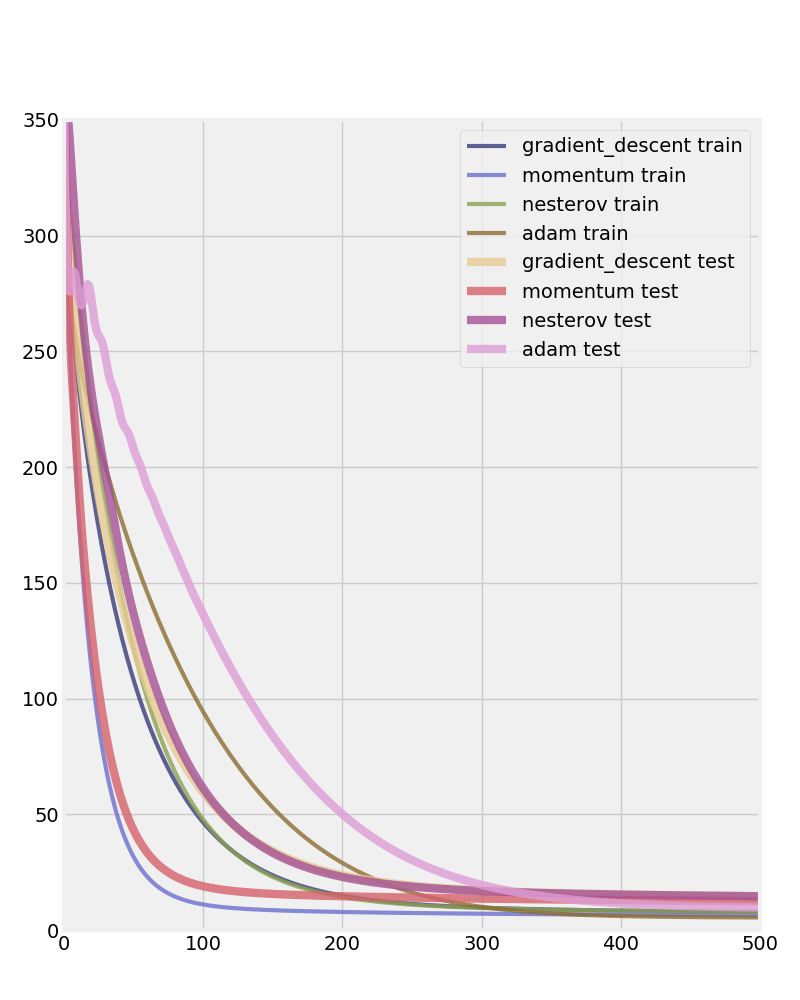

/home/tux/miniconda3/envs/ml2018/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The Vega20b colormap was deprecated in version 2.0. Use tab20b instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [5]:
optimizers = {
    "gradient_descent": gradient_descent(
        f=LinearRegressionOnDataset(X_train, Y_train),
        starting_point=starting_point,
        learning_rate=.01),
    "momentum": momentum(
        f=LinearRegressionOnDataset(X_train, Y_train),
        starting_point=starting_point,
        learning_rate=.01,
        gamma=.6),
    "nesterov": nesterov(
        f=LinearRegressionOnDataset(X_train, Y_train),
        starting_point=starting_point,
        learning_rate=.001,
        gamma=.9),
    "adam": adam(
        f=LinearRegressionOnDataset(X_train, Y_train),
        starting_point=starting_point,
        learning_rate=.1,
        beta1=0.9,
        beta2=0.999,
        epsilon=1e-8)}

f_test = {
    "gradient_descent": LinearRegressionOnDataset(X_test, Y_test),
    "momentum": LinearRegressionOnDataset(X_test, Y_test),
    "nesterov": LinearRegressionOnDataset(X_test, Y_test),
    "adam": LinearRegressionOnDataset(X_test, Y_test)}

def colors_gen(n):
    cmap = matplotlib.cm.get_cmap('Vega20b')
    for i in np.linspace(0., 1., n):
        yield cmap(i)

colors = colors_gen(8)

fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(1, 1, 1)
lines = {k: ax.plot([], label=k+" train", lw=3, alpha=.8, c=next(colors))[0] for k in optimizers.keys()}
test_lines = {k: ax.plot([], label=k+" test",lw=6, alpha=.8, c=next(colors))[0] for k in optimizers.keys()}
values = {k: [] for k in optimizers.keys()}
test_values = {k: [] for k in optimizers.keys()}
ax.legend()
ax.set_xlim(0, 500)
ax.set_ylim(0, 350)

def frame_processor(frame):
    for k, v in frame.items():
        w, score, _ = v
        values[k].append(score)
        test_values[k].append(f_test[k](w))
        lines[k].set_data(list(range(len(values[k]))), values[k])
        test_lines[k].set_data(list(range(len(values[k]))), test_values[k])
    return tuple(lines.values()) + tuple(test_lines.values())

def yield_n_dicts(generators, n):
    i = 0
    while i < n:
        yield {k: next(v) for k, v in generators.items()}
        i += 1

ani = animation.FuncAnimation(
    fig,
    frame_processor,
    yield_n_dicts(optimizers, n=500),
    blit=True,
    interval=10,
    repeat=False)    
